# 05_modeling.ipynb

# -----------------
# Toronto Rentals: Modeling Notebook
# Goal: Predict rent price per square foot ($/sqft)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------------------------------------------------------------------
# Load data
# -------------------------------------------------------------------

In [2]:
df = pd.read_csv("../data/processed/rentals_features.csv")

features = [
    "sqft", "bedrooms", "bathrooms", "bed_bath_ratio",
    "dist_km_to_station", "distance_to_union", "dist_km_to_university"
]
target = "price_per_sqft"

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------------------------------------------------
# Helper function
# -------------------------------------------------------------------

In [3]:
def eval_model(name, y_true, y_pred):
    return {
        "model": name,
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
        "R2": float(r2_score(y_true, y_pred)),
    }

results = []

# -------------------------------------------------------------------
# Models
# -------------------------------------------------------------------

# Linear Regression

In [4]:
lin = LinearRegression().fit(X_train, y_train)
yhat_lin = lin.predict(X_test)
results.append(eval_model("Linear", y_test, yhat_lin))


# Log-Linear Regression

In [5]:
y_train_log = np.log1p(y_train)
lin_log = LinearRegression().fit(X_train, y_train_log)
yhat_log = np.expm1(lin_log.predict(X_test))
results.append(eval_model("Log-Linear", y_test, yhat_log))

# Random Forest

In [6]:
rf_pps = RandomForestRegressor(
    n_estimators=500, max_depth=12, random_state=42
).fit(X_train, y_train)
yhat_rf = rf_pps.predict(X_test)
results.append(eval_model("RandomForest", y_test, yhat_rf))

# Gradient Boosting

In [7]:
gbr = GradientBoostingRegressor(
    n_estimators=300, learning_rate=0.1, max_depth=4, random_state=42
).fit(X_train, y_train)
yhat_gbr = gbr.predict(X_test)
results.append(eval_model("GradientBoosting", y_test, yhat_gbr))

# -------------------------------------------------------------------
# Results table
# -------------------------------------------------------------------

In [8]:
metrics_df = pd.DataFrame(results).sort_values("MAE")
display(metrics_df)

# Save results
VIS_DIR = Path("../visuals")
VIS_DIR.mkdir(parents=True, exist_ok=True)
metrics_df.to_csv(VIS_DIR / "model_metrics.csv", index=False)

,model,MAE,RMSE,R2
2,RandomForest,0.316845,0.404440,0.507283
3,GradientBoosting,0.322035,0.429931,0.443216
0,Linear,0.349439,0.439105,0.419202
1,Log-Linear,0.373393,0.472781,0.326701


# -------------------------------------------------------------------
# Predicted vs Actual Plot (best model)
# -------------------------------------------------------------------

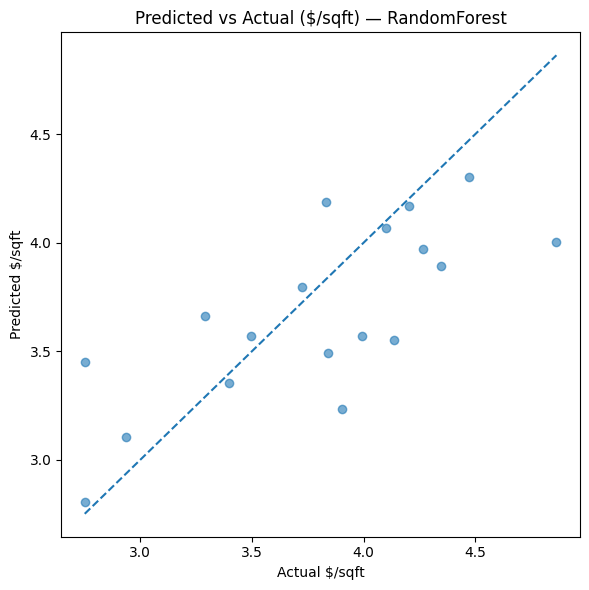

In [9]:
best_name = metrics_df.iloc[0]["model"]
best_pred = {
    "Linear": yhat_lin,
    "Log-Linear": yhat_log,
    "RandomForest": yhat_rf,
    "GradientBoosting": yhat_gbr
}[best_name]

plt.figure(figsize=(6,6))
plt.scatter(y_test, best_pred, alpha=0.6)
lims = [min(y_test.min(), best_pred.min()), max(y_test.max(), best_pred.max())]
plt.plot(lims, lims, linestyle="--")
plt.xlabel("Actual $/sqft")
plt.ylabel("Predicted $/sqft")
plt.title(f"Predicted vs Actual ($/sqft) — {best_name}")
plt.tight_layout()
plt.savefig(VIS_DIR / "predicted_vs_actual.png", dpi=300)
plt.show()

# -------------------------------------------------------------------
# Feature Importance (Random Forest only)
# -------------------------------------------------------------------

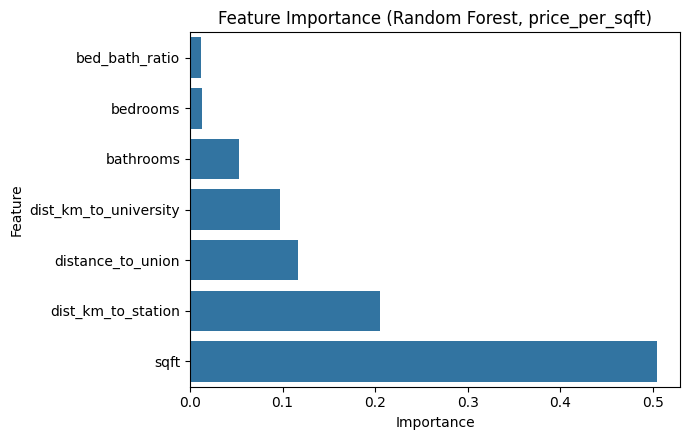

In [10]:
imp = pd.Series(rf_pps.feature_importances_, index=features).sort_values(ascending=True)

plt.figure(figsize=(7,4.5))
sns.barplot(x=imp.values, y=imp.index)
plt.title("Feature Importance (Random Forest, price_per_sqft)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig(VIS_DIR / "feature_importance_rf.png", dpi=300)
plt.show()

# -------------------------------------------------------------------
# Residuals plot (Random Forest)
# -------------------------------------------------------------------

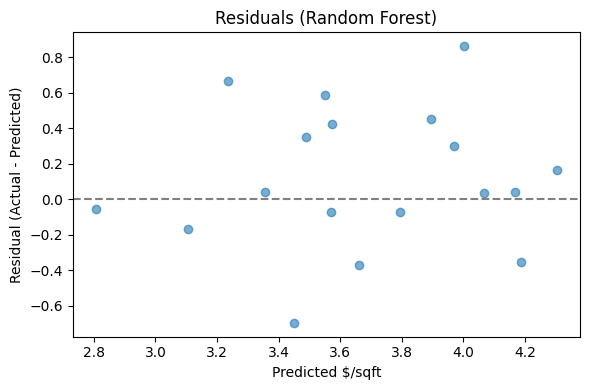

In [11]:
resid = y_test - yhat_rf
plt.figure(figsize=(6,4))
plt.scatter(yhat_rf, resid, alpha=0.6)
plt.axhline(0, linestyle="--", color="gray")
plt.xlabel("Predicted $/sqft")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals (Random Forest)")
plt.tight_layout()
plt.savefig(VIS_DIR / "residuals_rf.png", dpi=300)
plt.show()